# My First PyTorch Neural Network 

### Disecting  a [tutorial](https://youtu.be/i2yPxY2rOzs) from [Sentdex](https://www.youtube.com/channel/UCfzlCWGWYyIQ0aLC5w48gBQ).

In [27]:
# import PyTorch
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
# embed static images in the ipynb
%matplotlib inline 

# neural network package
import torch.nn as nn 
import torch.nn.functional as F

Usually, you'll need both `torch.nn` and `torch.nn.functional` if you're working with NNs. 

In [28]:
from torchvision import transforms, datasets

Getting data from torchvision.datasets is cheating since most of your time will be spent on preparing your dataset. However, this will make other concepts easier to learn for now. 

In [29]:
# import MNIST dataset
from torchvision.datasets import MNIST

```python
MNIST('/data') # This will give you the following error
``` 
```
RuntimeError: Dataset not found. You can use download=True to download it
```

In [30]:
train = datasets.MNIST("./data", train=True, download=True, 
                      transform = transforms.Compose([transforms.ToTensor()])) 
    # For some reason, the data in torchvision.datasets doesn't come 
    # in tensor form. transforms.Compose([transforms.ToTensor()]) fixes that
test = datasets.MNIST("./data", train=False, download=True, 
                      transform = transforms.Compose([transforms.ToTensor()]))

In [31]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

Why the `batch_size` parameter? 

Normally, datasets are so large that they may not fit on memory. We'll often train the neural networks in batches, which each have `batch_size` number of samples. 

Using a higher batch size generally helps training time, but there is a sweet spot. [Sentdex](https://www.youtube.com/channel/UCfzlCWGWYyIQ0aLC5w48gBQ) recommends somewhere between 8 and 64. 

In [32]:
# prints `batch_size` number of input-output pairs
for data in trainset:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [33]:
type(data)

list

In [34]:
len(data)

2

In [35]:
for item in data:
    print(type(item))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


So, `data` is a list of tensors.

In [36]:
data[0].shape

torch.Size([10, 1, 28, 28])

In [37]:
data[0].size()

torch.Size([10, 1, 28, 28])

In [38]:
data[1].shape

torch.Size([10])

In [39]:
data[1][1] # label of the second image

tensor(4)

In [40]:
data[0][1].shape # tensor of the second image

torch.Size([1, 28, 28])

The shape of this image is 28 by 28.

In [41]:
import matplotlib.pyplot as plt

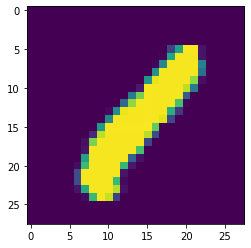

In [21]:
plt.imshow(data[0][1].view(28, 28))
plt.show()

In general, we want the dataset to be as balanced as possible so that the model doesn't train itself into a local minima of loss that it cannot get out of. Below is a scheme for checking how balanced the dataset is.

In [22]:
# Build dictionary of target counts 
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

total = 0
for data in trainset:
    Xs, Ys = data 
    for Y in Ys:
        counter_dict[int(Y)] += 1
        total += 1

print(counter_dict)

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [23]:
def counts_barplot():
    x = list(counter_dict.keys())
    y = list(counter_dict.values())
    ax = sns.barplot(x, y)
    ax.set(title='Dataset Balance Chart', 
           xlabel='Digit', ylabel='Count')
    plt.show()

counts_barplot()

NameError: name 'sns' is not defined

In [ ]:
# print dataset balance percentages using f string
for i in counter_dict:
    proportion = counter_dict[i]/total*100
    print(f'{i}: {proportion:.2f}')

- f-string tutorial: [reference](https://realpython.com/python-f-strings/#old-school-string-formatting-in-python)
- How to change the number of digits in f-string expression: [reference](https://stackoverflow.com/questions/45310254/fixed-digits-after-decimal-with-f-strings)

In [24]:
data[0][0].shape

torch.Size([1, 28, 28])

In [240]:
class Net(nn.Module): # class inherits from nn.Module
    def __init__(self):
        super().__init__() # initialize nn.Module
        # fc1 -> first fully connected layer
        # apply linear transformation on incoming data
        self.fc1 = nn.Linear(in_features=28*28, 
                             out_features=64)
        """ nn.Linear(in_features, out_features, bias=True)
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
        """
        # fc2 must take in 64
        self.fc2 = nn.Linear(in_features=64, 
                             out_features=64)
        self.fc3 = nn.Linear(in_features=64, 
                             out_features=64)
        # 10 classes -> output layer should have 10 nodes 
        self.fc4 = nn.Linear(in_features=64, 
                             out_features=10)
    
    def forward(self, x): # defines the forward propagation
        # relu is an activation function
        x = F.relu(self.fc1(x)) # relu on first layer
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # Output layer needs a multiclassifying transformation
        # log softmax works for this
        x = self.fc4(x) 
        return F.log_softmax(x, dim=1)
        
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


When you inherit, you inherit the methods and attributes the other module (`nn.Module`), however the initialization does not run. If you want the parent module to initialize too, you run `super().__init__()`.

In [241]:
X = torch.rand((28,28))

You'll get an error from running
`output = net(X)` :

`RuntimeError: size mismatch, m1: [28 x 28], m2: [784 x 64]`

In [250]:
X = torch.rand((28,28))
X = X.view(-1, 28 * 28)
# pass data through the NN and get return
output = net(X)
output

tensor([[-2.1542, -2.4014, -2.1882, -2.3896, -2.3724, -2.3394, -2.3511, -2.3672,
         -2.2721, -2.2268]], grad_fn=<LogSoftmaxBackward>)

In [256]:
# optimize with Adam algorithm.
optimizer = torch.optim.Adam(net.parameters())
""" torch.optim.Adam?
torch.optim.Adam(
    params,
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,)
Args:
    params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
    lr (float, optional): learning rate (default: 1e-3)
    betas (Tuple[float, float], optional): coefficients used for computing
"""

n_epochs = 3 # num of full passes throuagh data
for epoch in range(n_epochs):
    for data in trainset:
        # data is a batch w/ featurs and targets
        X, Y = data
        net.zero_grad() # Zero the gradient buffers of all params
        output = net(X.view(-1, 28*28))
        
        # Loss metric: nll -> negative log likelihood 
        loss = F.nll_loss(output, Y) 
        # Use nll_loss when data is scalar
        # Use MSE when data is one-hot
        
        loss.backward() # backward
        optimizer.step() # adjusts weights
    print(loss) # should see loss decreasing

tensor(0.0832, grad_fn=<NllLossBackward>)
tensor(0.0580, grad_fn=<NllLossBackward>)
tensor(0.2262, grad_fn=<NllLossBackward>)


Q: What is `loss.backward` doing?

When you call `loss.backward()`, PyTorch computes the gradient of loss w.r.t all the parameters in loss that have `requires_grad = True` and store them in `parameter.grad` attribute for every parameter.

Q: What is `optimizer.step` doing?

`optimizer.step()` updates all the parameters based on `parameter.grad`

In [264]:
correct = 0
total = 0

# without calculating gradients:
with torch.no_grad():
    # for data vector in dataset
    for data in testset:
        # X, Y are the feature and target vectors
        X, Y = data
        output = net(X.view(-1, 28*28))
        
        for idx, i in enumerate(output):
            if torch.argmax(i) == Y[idx]:
                correct += 1
            total += 1
print(f"Accuracy: {(correct/total):.3f}")

Accuracy: 0.972


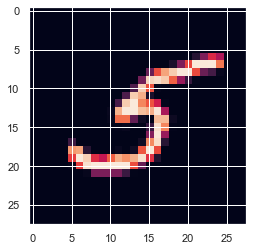

In [265]:
# display the X[0] image
plt.imshow(X[0].view(28,28))
plt.show()

In [266]:
# Print prediction -> pass X[0] thru NN
print(torch.argmax(net(X[0].view(-1, 28*28))[0]))
# X[0].view(-1, 28*28) -> reshapes for NN

tensor(5)
